# Create SiPM PSF for NEXT-100, to use with Beersheba.

This notebook shows how to extract the PSFs from Kr events and their reading.

In [1]:
import os
import glob
import numpy  as np
import pandas as pd
import tables as tb

from invisible_cities.reco.psf_functions    import create_psf
from invisible_cities.reco.psf_functions    import hdst_psf_processing
from invisible_cities.reco.psf_functions    import add_empty_sensors_and_normalize_q
from invisible_cities.reco.psf_functions    import add_variable_weighted_mean

import invisible_cities.core.core_functions as     coref
import invisible_cities.io  .dst_io         as     dstio

from invisible_cities.database              import load_db
from invisible_cities.io      .kdst_io      import psf_writer

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]          = 10, 10
plt.rcParams["font.size"]               = 16
plt.rcParams["figure.max_open_warning"] = 100

In [3]:
db = load_db.DataSiPM('next100', -1)

In [20]:
# Input and output path
psf_path   = '/data_extra2/paolafer/SimMC/next100/psf/'
psf_filename = 'next100.kr83m.psf.h5'
out_psf  = psf_path + psf_filename

psf_files = glob.glob(psf_path+'psf_*.h5')

In [12]:
psf_files[0]

'/data_extra2/paolafer/SimMC/next100/psf/psf_1.h5'

### Check that penthesilea files are correct

In [7]:
myfile = ['/data_extra2/paolafer/SimMC/next100/psf/next100.kr83m.1.psf_hits.h5']
df = dstio.load_dsts(myfile, 'RECO', 'Events').drop(['Xrms', 'Yrms', 'Qc', 'Ec', 'track_id'], 
                                                    axis='columns').reset_index(drop=True)

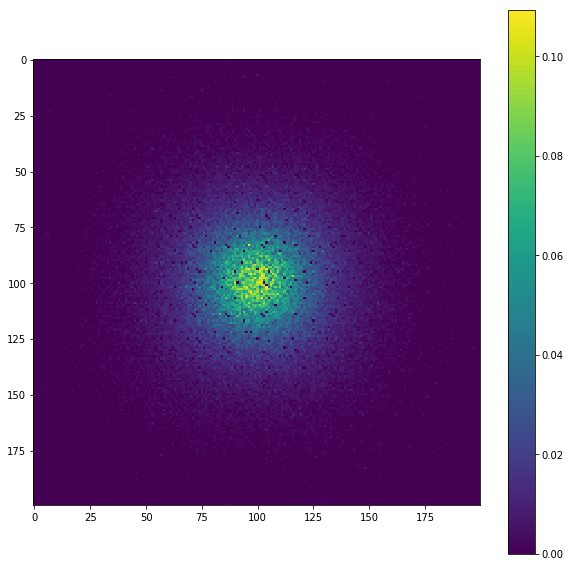

In [8]:
### Use all z to have more statistics
plt.rcParams["figure.figsize"]  = 10, 10

bin_size   = 1
Xrange     = [ -100, 100]
Yrange     = [ -100, 100]
ranges     = [Xrange, Yrange]
nbinX      = int(np.diff(Xrange)/bin_size)
nbinY      = int(np.diff(Yrange)/bin_size)

hdstA = hdst_psf_processing(df, [Xrange, Yrange], db)
hdst = hdstA[coref.in_range(hdstA.Z, 0, 2000)]
bin_edges = [np.linspace(*rr, [nbinX, nbinY][i]+1) for i, rr in enumerate([Xrange, Yrange])]
psf_new, entries_new, bins_new = create_psf((hdst.RelX.values, hdst.RelY.values), hdst.NormQ, 
                                             bin_edges)
plt.imshow(psf_new)
plt.colorbar()

### Code to create PFS

In [9]:
## This function is using one big bin in xy.
## in the writer function, 0., 0. are the xy average of the particular xy bin. Other two loops should be addes
## if more bins were to be used.

def compute_psf(df, fnumber):
    out_psf = psf_path + 'psf_prova_{}.h5'.format(fnumber)
#    print(out_psf)

    with tb.open_file(out_psf, 'w') as outfile:
        # Declare the PSF writer
        writer = psf_writer(outfile)

        for z in zrange:
            z_sel = coref.in_range(df.Z, z, z+z_step) 
            # Preprocess the data before extracting the PSF
            hdst = hdst_psf_processing(df[z_sel], [Xrange, Yrange], the_db)
            # Safety check (single sipm events not considered to be physical)
            hdst = hdst[hdst.nsipm > 1]

            # Loop to extract the PSF in different regions.
            bin_edges = [np.linspace(*rr, [nbinX, nbinY][i]+1) for i, rr in enumerate([Xrange, Yrange])]
            psf_new, entries_new, bins_new = create_psf((hdst.RelX.values, hdst.RelY.values), hdst.NormQ, 
                                                         bin_edges)

            writer(bins_new[0], bins_new[1], [0], 0., 0., z + z_step/2, 
                           np.asarray([psf_new]).transpose((1, 2, 0)), np.asarray([entries_new]).transpose((1, 2, 0)))

In [13]:
run = -1
the_db = load_db.DataSiPM('next100', run)

z_max  = 1205
z_step = 1205
zrange = []
zrange.extend(np.arange(0, z_max, z_step))

### PSF binning and range
bin_size   = 1
Xrange     = [ -100, 100]
Yrange     = [ -100, 100]
ranges     = [Xrange, Yrange]
nbinX      = int(np.diff(Xrange)/bin_size)
nbinY      = int(np.diff(Yrange)/bin_size)

i = 1
thefile = myfile[0].format(i)
df = dstio.load_dsts([thefile], 'RECO', 'Events').drop(['Xrms', 'Yrms', 'Qc', 'Ec', 'track_id'], axis='columns').reset_index(drop=True)
compute_psf(df, i)

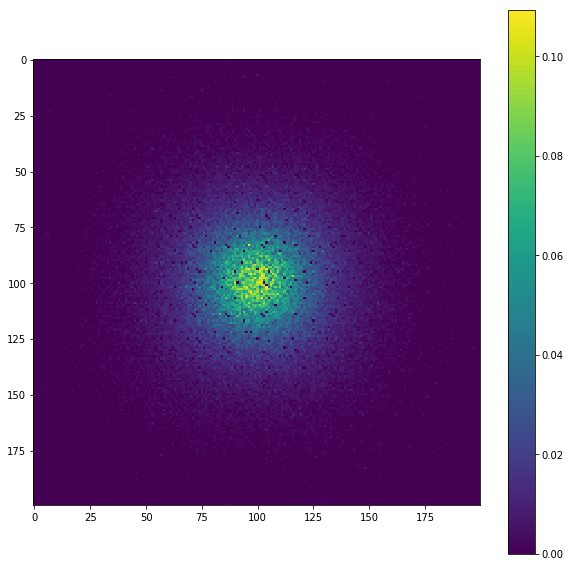

In [14]:
## cross check
plt.imshow(psf_new)
plt.colorbar()

### Read back the psf file

In [16]:
psf = pd.read_hdf(psf_path + 'psf_prova_1.h5')
print(psf.head())

   nevt    xr    yr   zr    x    y      z  factor
0     5 -99.5 -99.5  0.0  0.0  0.0  602.5     0.0
1     7 -99.5 -98.5  0.0  0.0  0.0  602.5     0.0
2     3 -99.5 -97.5  0.0  0.0  0.0  602.5     0.0
3     3 -99.5 -96.5  0.0  0.0  0.0  602.5     0.0
4     1 -99.5 -95.5  0.0  0.0  0.0  602.5     0.0


/home/paolafer/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.
  del sys.path[0]


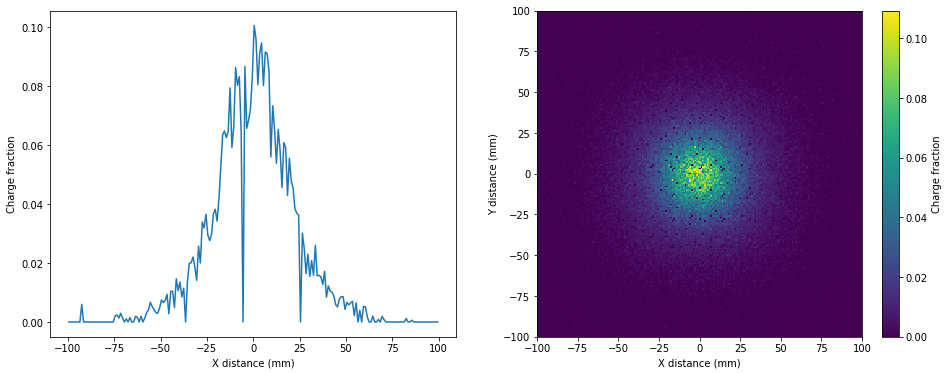

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

### Plot PSF at center (X dimension)
p1 = psf[(psf.z==602.5) & (psf.yr==0.5)]
x, y = sorted(set(p1.xr)), p1.groupby(['xr'])['factor'].sum().values
axes[0].plot(x, y)
axes[0].set_xlabel('X distance (mm)')
axes[0].set_ylabel('Charge fraction')

### PSF (2D)
p1 = psf[(psf.z==602.5)]
x, y, e = p1.xr.values, p1.yr.values, p1.factor.values
xb, yb  = np.linspace(*Xrange, np.diff(Xrange)+1), np.linspace(*Yrange, np.diff(Yrange)+1)
img = axes[1].hist2d(x, y, bins=[xb,yb], weights=e)
axes[1].set_xlabel('X distance (mm)')
axes[1].set_ylabel('Y distance (mm)')
cb = fig.colorbar(img[3], ax=axes[1])

cb.set_label('Charge fraction')

# Join all PSFs

Once all psf files have been created, let's join them to use one file.

In [23]:
# Input and output path

psf_filename = 'next100.kr83m.psf.h5'
out_psf  = psf_path + psf_filename

psf_files = glob.glob(psf_path + 'psf_*.h5')

In [24]:
psf_files

['/data_extra2/paolafer/SimMC/next100/psf/psf_1.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_100.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_101.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_102.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_103.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_104.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_105.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_106.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_107.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_108.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_109.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_10.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_110.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_111.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_112.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_113.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_114.h5',
 '/data_extra2/paolafer/SimMC/next100/psf/psf_115.h5',
 '/data_extra

In [25]:
df_psf = pd.read_hdf(psf_files[0])

In [26]:
df_psf

,nevt,xr,yr,zr,x,y,z,factor
0,0,-99.5,-99.5,0.0,0.0,0.0,10.0,0.0
1,0,-99.5,-98.5,0.0,0.0,0.0,10.0,0.0
2,0,-99.5,-97.5,0.0,0.0,0.0,10.0,0.0
3,0,-99.5,-96.5,0.0,0.0,0.0,10.0,0.0
4,0,-99.5,-95.5,0.0,0.0,0.0,10.0,0.0
5,0,-99.5,-94.5,0.0,0.0,0.0,10.0,0.0
6,0,-99.5,-93.5,0.0,0.0,0.0,10.0,0.0
7,0,-99.5,-92.5,0.0,0.0,0.0,10.0,0.0
8,0,-99.5,-91.5,0.0,0.0,0.0,10.0,0.0
9,0,-99.5,-90.5,0.0,0.0,0.0,10.0,0.0


In [39]:
evts    = []
factors = []

for i in range(1, 1001):
    filein = psf_path + f'psf_{i}.h5'
    try:
        df = pd.read_hdf(filein)
    except:
        print(f'{filein} not found')
        continue
        
    if len(df.nevt.values) != 2440000:
        print(i, len(df.nevt.values))
    evts   .append(df.nevt  .values)
    factors.append(df.factor.values)

#for i, filein in enumerate(psf_files):
#    if i % 10 == 0:
#        print(f'{i} files read, current file: {filein}')
#    df = pd.read_hdf(filein)
#    evts   .append(df.nevt  .values)
#    factors.append(df.factor.values)

/data_extra2/paolafer/SimMC/next100/psf/psf_4.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_6.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_8.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_13.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_14.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_16.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_211.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_276.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_282.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_291.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_298.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_516.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_985.h5 not found
/data_extra2/paolafer/SimMC/next100/psf/psf_1000.h5 not found


In [40]:
len(evts), len(factors)

(986, 986)

In [11]:
np.array(evts).sum(axis=0)#.ast

MemoryError: 

In [41]:
evts_all    = np.array(evts)
factors_all = np.array(factors)

In [37]:
for i in range(len(evts_all)):
    if len(evts_all[i]) != 2440000:
        print(i, len(evts_all[i]))

120 2400000
969 2400000


In [42]:
new_evts = evts_all.sum(axis=0).astype('int32')

In [43]:
tmp_factors = (evts_all * factors_all).sum(axis=0)

In [44]:
new_factors = tmp_factors / new_evts

In [45]:
df_psf.nevt   = new_evts
df_psf.factor = new_factors

In [46]:
df_psf.head()

,nevt,xr,yr,zr,x,y,z,factor
0,49,-99.5,-99.5,0.0,0.0,0.0,10.0,0.0
1,53,-99.5,-98.5,0.0,0.0,0.0,10.0,0.0
2,52,-99.5,-97.5,0.0,0.0,0.0,10.0,0.0
3,47,-99.5,-96.5,0.0,0.0,0.0,10.0,0.0
4,50,-99.5,-95.5,0.0,0.0,0.0,10.0,0.0


In [47]:
df_psf.dtypes

nevt        int32
xr        float32
yr        float32
zr        float32
x         float32
y         float32
z         float32
factor    float64
dtype: object

### Write the file in the correct format

In [48]:
from invisible_cities.evm.nh5     import PSFfactors
from invisible_cities.io.table_io import make_table

with tb.open_file(out_psf, 'w') as outfile:
    psf_table = make_table(outfile,
                           group       = "PSF",
                           name        = "PSFs",
                           fformat     = PSFfactors,
                           description = "XYZ dependent point spread functions",
                           compression = 'ZLIB4')

    row = psf_table.row
    for xr, yr, zr, x, y, z, f, ne in zip(df_psf.xr.values, df_psf.yr.values, df_psf.zr.values, 
                                          df_psf.x.values, df_psf.y.values, df_psf.z.values, 
                                          df_psf.factor.values, df_psf.nevt.values):
        row["xr"    ] = xr
        row["yr"    ] = yr
        row["zr"    ] = zr
        row["x"     ] = x
        row["y"     ] = y
        row["z"     ] = z
        row["factor"] = f
        row["nevt"  ] = ne
        row.append()

## Read the PSF

In [49]:
psf =  dstio.load_dst(out_psf, 'PSF', 'PSFs')

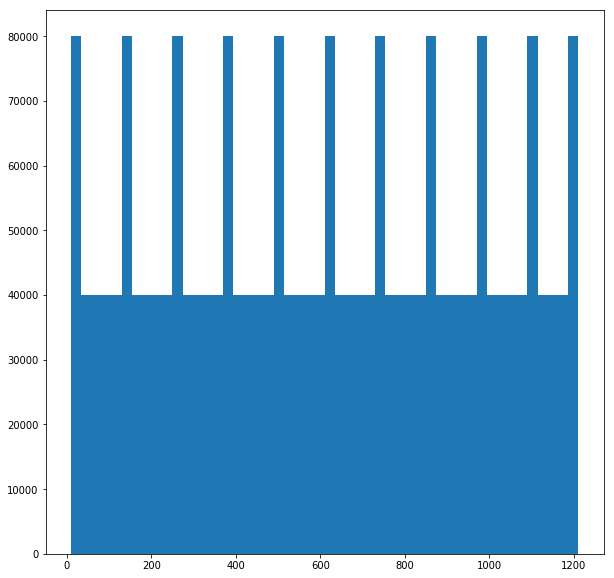

In [50]:
plt.hist(psf.z, bins=50);

In [59]:
psf[(psf.z > 600) & (psf.z < 630)]

,nevt,xr,yr,zr,x,y,z,factor
1200000,66,-99.5,-99.5,0.0,0.0,0.0,610.0,0.000000
1200001,76,-99.5,-98.5,0.0,0.0,0.0,610.0,0.000000
1200002,49,-99.5,-97.5,0.0,0.0,0.0,610.0,0.000000
1200003,63,-99.5,-96.5,0.0,0.0,0.0,610.0,0.000000
1200004,58,-99.5,-95.5,0.0,0.0,0.0,610.0,0.000000
1200005,65,-99.5,-94.5,0.0,0.0,0.0,610.0,0.000000
1200006,57,-99.5,-93.5,0.0,0.0,0.0,610.0,0.000000
1200007,50,-99.5,-92.5,0.0,0.0,0.0,610.0,0.000000
1200008,50,-99.5,-91.5,0.0,0.0,0.0,610.0,0.000000
1200009,53,-99.5,-90.5,0.0,0.0,0.0,610.0,0.000000


/home/paolafer/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.
  del sys.path[0]


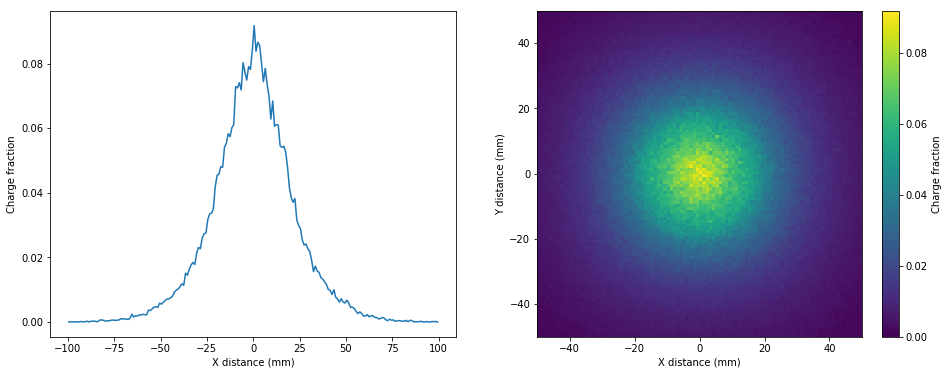

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

### Plot PSF at center (X dimension)
p1 = psf[(psf.z==610.) & (psf.yr==0.5)]
x, y = sorted(set(p1.xr)), p1.groupby(['xr'])['factor'].sum().values
axes[0].plot(x, y)
axes[0].set_xlabel('X distance (mm)')
axes[0].set_ylabel('Charge fraction')

### PSF (2D)
p1 = psf[(psf.z==610.)]
x, y, e = p1.xr.values, p1.yr.values, p1.factor.values
xb, yb  = np.linspace(*Xrange, np.diff(Xrange)+1), np.linspace(*Yrange, np.diff(Yrange)+1)
img = axes[1].hist2d(x, y, bins=[xb,yb], weights=e)
axes[1].set_xlabel('X distance (mm)')
axes[1].set_ylabel('Y distance (mm)')
axes[1].set_xlim(-50, 50)
axes[1].set_ylim(-50, 50)
cb = fig.colorbar(img[3], ax=axes[1])

cb.set_label('Charge fraction')